<a href="https://colab.research.google.com/github/maddy1096/CryptocurrencyPredictionAndAnalysis/blob/main/Prediction_code_of_EMA_and_Standard_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting the historical dataset of Bitcoin and Ethereum from cryptocompare API

In [1]:
import requests
import json
import pandas as pd
import datetime
import csv
def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
  
    return df

x = ['BTC', 'ETH']
for i in x:
  m = daily_price_historical(i,'USD')
  m['Symbol'] = i
  m.to_csv("./{0}_price.csv".format(i.replace("-","_")),index = False)

  print('Dataset of '+i+' has been created')

Dataset of BTC has been created
Dataset of ETH has been created


Preprocessing data for prediction of prices of bitcoins 

In [ ]:
x = ['BTC']
dfs = []
for m in x:
  filenames = '{}_price.csv'.replace('{}',m)
  df = pd.read_csv(filenames)
  #Drop all zeroes
  df = df[(df['high']!=0)]
  dfs.append(df)

big_frame = pd.concat(dfs, ignore_index=True)
big_frame_process = big_frame.drop(columns=['conversionSymbol','conversionType'])


high = big_frame_process.loc[:,'high'].to_numpy()
low_prices = big_frame_process.loc[:,'low'].to_numpy()
high_prices = (high+low_prices)/2.0


print(big_frame_process)
print(high_prices)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
big_frame_process['Symbol'] = le.fit_transform(big_frame_process['Symbol'])



            time         high          low  ...        close   timestamp  Symbol
0     1279324800      0.04951      0.04951  ...      0.04951  2010-07-17     BTC
1     1279411200      0.08585      0.05941  ...      0.08584  2010-07-18     BTC
2     1279497600      0.09307      0.07723  ...      0.08080  2010-07-19     BTC
3     1279584000      0.08181      0.07426  ...      0.07474  2010-07-20     BTC
4     1279670400      0.07921      0.06634  ...      0.07921  2010-07-21     BTC
...          ...          ...          ...  ...          ...         ...     ...
3935  1619308800  50576.40000  47073.07000  ...  49120.97000  2021-04-25     BTC
3936  1619395200  54389.71000  48843.41000  ...  54062.29000  2021-04-26     BTC
3937  1619481600  55490.94000  53357.59000  ...  55073.48000  2021-04-27     BTC
3938  1619568000  56461.55000  53886.63000  ...  54877.94000  2021-04-28     BTC
3939  1619654400  55217.24000  53552.13000  ...  54392.34000  2021-04-29     BTC

[3940 rows x 9 columns]
[4.

Splitting the data into training and test sets

In [ ]:
import pandas as pd
import numpy as np

train_data = high_prices[:3151]
test_data = high_prices[3151:]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data)

[[4.951000e-02]
 [7.263000e-02]
 [8.515000e-02]
 ...
 [3.853930e+03]
 [3.844395e+03]
 [3.818560e+03]]


Coverting series to sample

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 250
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


Reshaping and normalizing the data 

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

Smoothing data for EMA

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(3151):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

Training Standard average model

In [ ]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = big_frame_process.loc[pred_idx,'timestamp']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01420


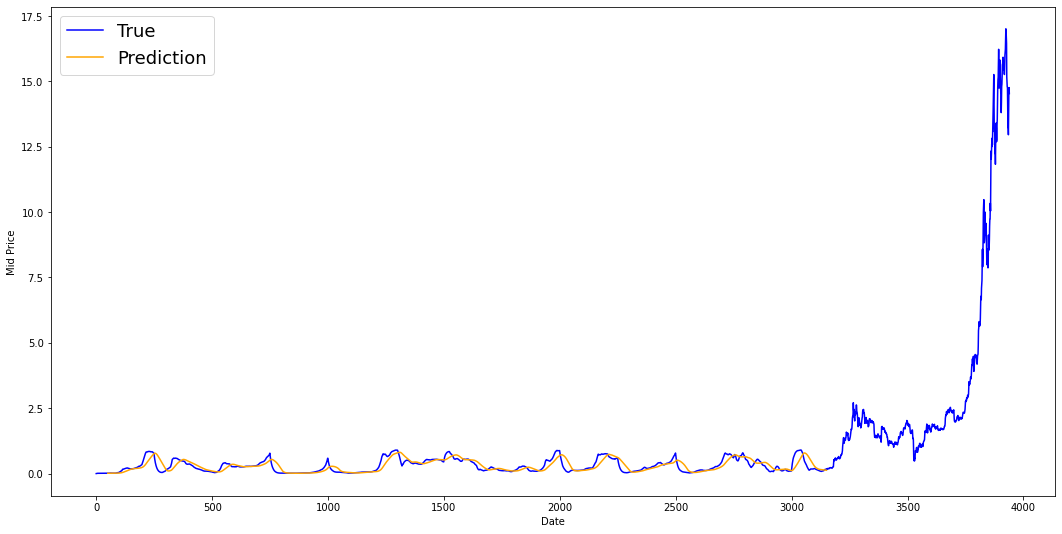

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.plot(range(big_frame_process.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Training EMA model

MSE error for EMA averaging: 0.00025


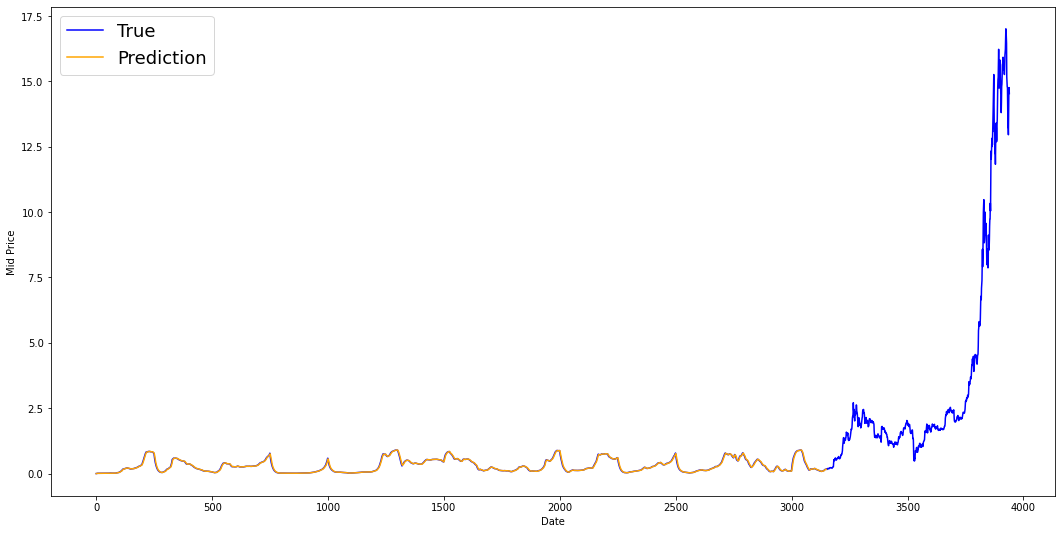

In [ ]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


plt.figure(figsize = (18,9))
plt.plot(range(big_frame_process.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()
